In [199]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import random
import rasterio
from tensorflow.keras.utils import to_categorical
from skimage.io import imread
from tensorflow.keras.callbacks import ModelCheckpoint

In [200]:
image_dir = r'C:\Users\HP\Downloads\data-20240831T224535Z-001\data\images'
label_dir = r'C:\Users\HP\Downloads\data-20240831T224535Z-001\data\labels'
# Load image and label filenames
imgs = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
labels = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')])


In [201]:
def load_images_from_directory(directory_path):
    images = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.png') or file_name.endswith('.tif'):  # Adjust based on image format
            file_path = os.path.join(directory_path, file_name)
            image = imread(file_path)
            images.append(image)
    return np.array(images)

# Example usage
labels = load_images_from_directory(label_dir)
imgs = load_images_from_directory(image_dir)

In [202]:
# List all files in the directory
all_files = os.listdir(label_dir)

# Filter out files that have an underscore in their name
unwanted_files = [file for file in all_files if "_" in file]

# Remove unwanted files
for file in unwanted_files:
    file_path = os.path.join(label_dir, file)
    os.remove(file_path)
    print(f"Removed {file}")

print("Cleanup complete!")

Cleanup complete!


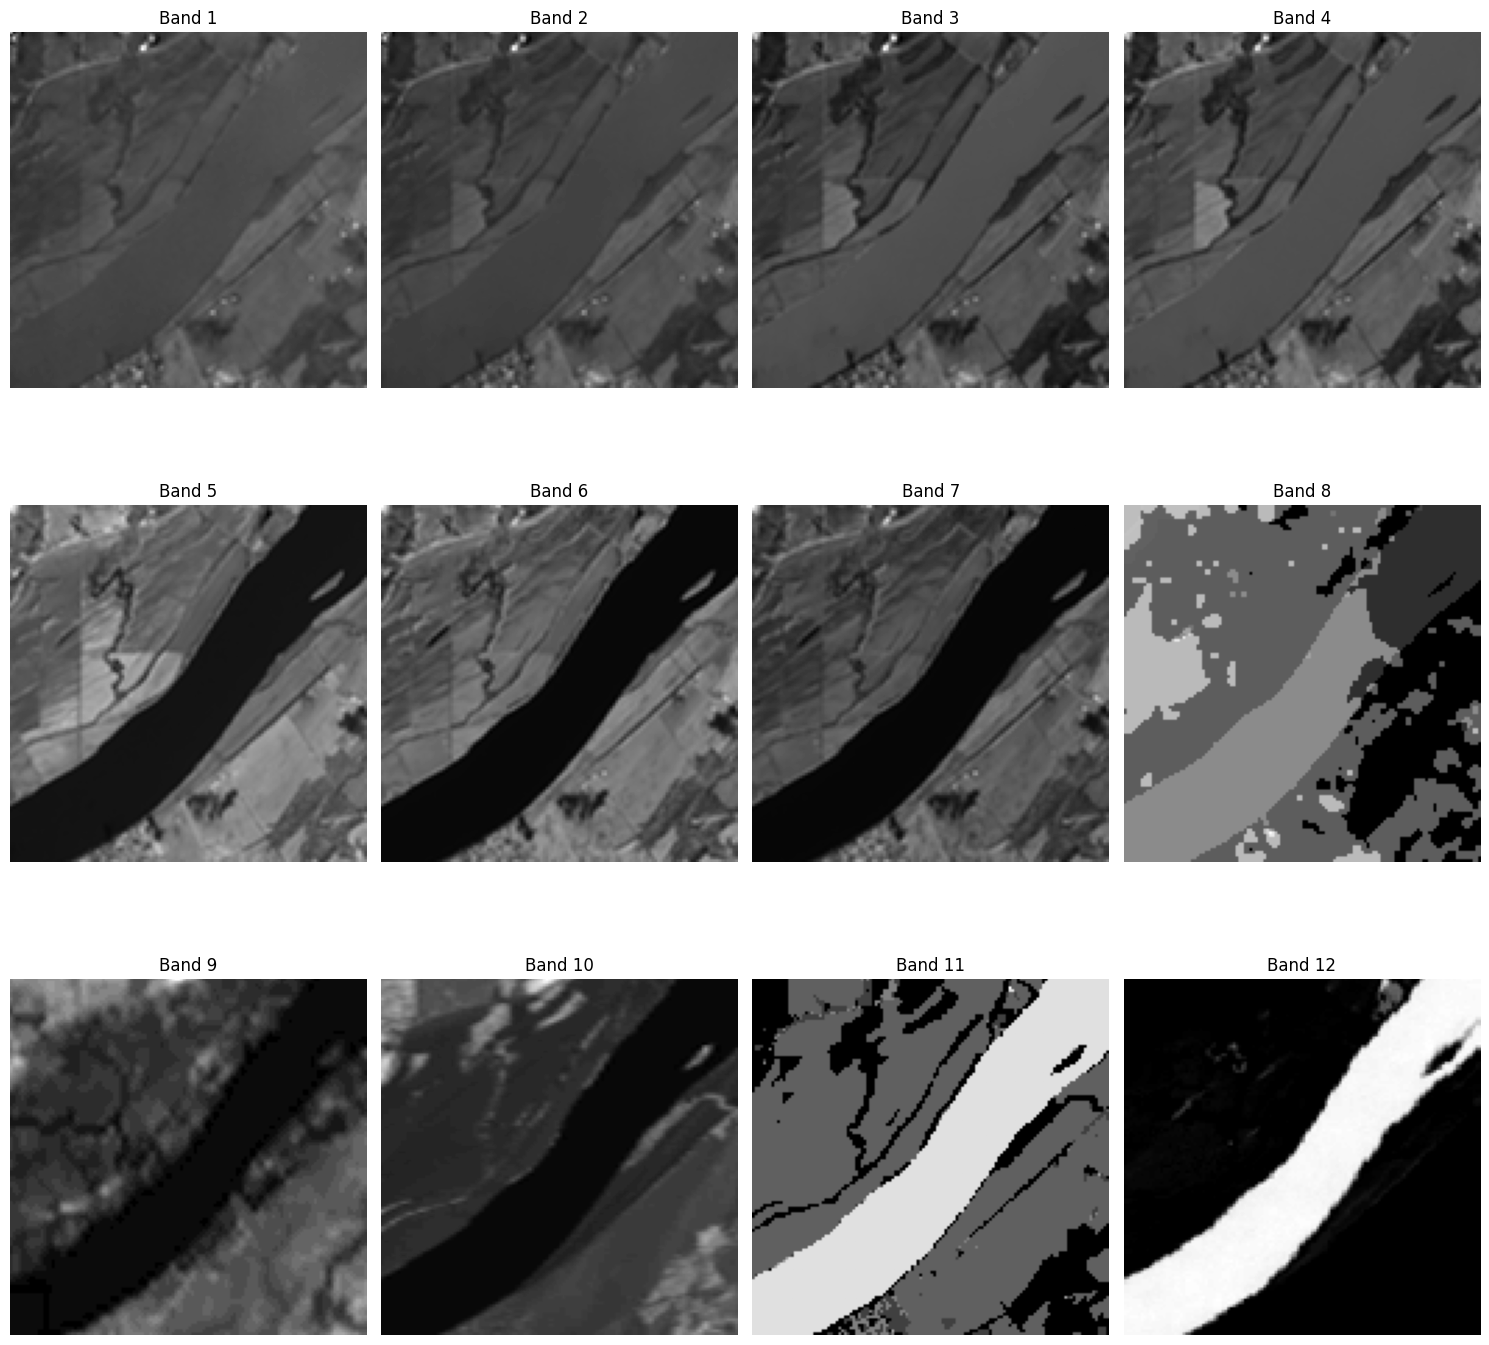

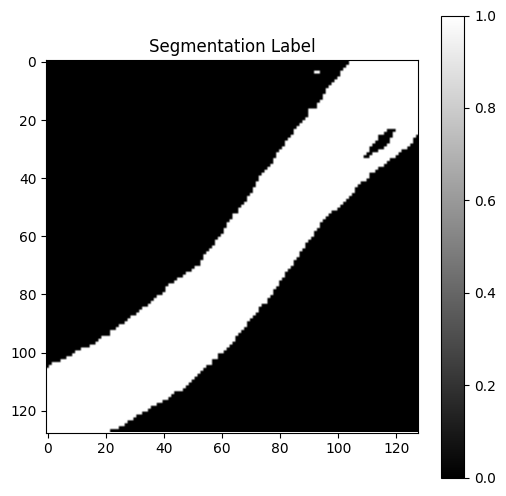

305


In [203]:

# Function to load and print bands of a random satellite image in sets of 3 or 4
def print_image_bands_and_label(image_dir, label_dir, bands_per_row=4):
    # List all images in the directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    # Select a random image
    random_image_file = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image_file)
    image_name = random_image_file.split('.')[0]
    
    # Load the image using rasterio
    with rasterio.open(image_path) as src:
        # Read all bands
        bands = src.read()  # This will give a 3D array (bands, height, width)
        num_bands = bands.shape[0]
        
        # Calculate how many rows of subplots we'll need
        rows = (num_bands + bands_per_row - 1) // bands_per_row  # Ceiling division
        
        # Create subplots for the bands
        fig, axes = plt.subplots(rows, bands_per_row, figsize=(15, 5 * rows))
        axes = axes.flatten()  # Flatten in case there's more than 1 row
        
        for i in range(num_bands):
            ax = axes[i]
            ax.set_title(f"Band {i + 1}")
            ax.imshow(bands[i], cmap='gray')  # Display each band in grayscale
            ax.axis('off')
        
        # Hide any remaining empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()

    label_file = image_name + '.png'
    label_path = os.path.join(label_dir, label_file)
    
    # Load and print the label (segmentation mask or class label)
    with rasterio.open(label_path) as label_src:
        label = label_src.read(1)  # Assuming label is stored in a single band
        plt.figure(figsize=(6, 6))
        plt.title("Segmentation Label")
        plt.imshow(label, cmap='gray')  # Display the segmentation mask
        plt.colorbar()
        plt.show()
    print(image_name)
# Call the function with the appropriate directories
print_image_bands_and_label(image_dir, label_dir, bands_per_row=4)  # You can set bands_per_row=4 if preferred

In [204]:
import tifffile as tiff
import numpy as np
import os

def normalize_tif_images_with_tifffile(dataset_path):
    normalized_images = []
    
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".tif"):
            file_path = os.path.join(dataset_path, file_name)
            
            try:
                # Open the .tif image using tifffile
                img = tiff.imread(file_path)
                
                # Convert the image to float32 for normalization
                img_array = img.astype(np.float32)
                
                # Apply min-max normalization
                min_val = np.min(img_array)
                max_val = np.max(img_array)
                img_normalized = (img_array - min_val) / (max_val - min_val)
                
                normalized_images.append(img_normalized)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    return normalized_images

# Example usage
normalized_images = normalize_tif_images_with_tifffile(image_dir)


In [205]:
def check_normalization(images):
    for i, img in enumerate(images):
        min_val = np.min(img)
        max_val = np.max(img)
        print(f"Image {i}: Min Value = {min_val}, Max Value = {max_val}")
        
        # Raise a warning if the values are out of bounds
        if min_val < 0 or max_val > 1:
            print(f"Warning: Image {i} is not properly normalized!")
        else:
            print(f"Image {i} is properly normalized.")

# Example usage
check_normalization(normalized_images)

Image 0: Min Value = 0.0, Max Value = 1.0
Image 0 is properly normalized.
Image 1: Min Value = 0.0, Max Value = 1.0
Image 1 is properly normalized.
Image 2: Min Value = 0.0, Max Value = 1.0
Image 2 is properly normalized.
Image 3: Min Value = 0.0, Max Value = 1.0
Image 3 is properly normalized.
Image 4: Min Value = 0.0, Max Value = 1.0
Image 4 is properly normalized.
Image 5: Min Value = 0.0, Max Value = 1.0
Image 5 is properly normalized.
Image 6: Min Value = 0.0, Max Value = 1.0
Image 6 is properly normalized.
Image 7: Min Value = 0.0, Max Value = 1.0
Image 7 is properly normalized.
Image 8: Min Value = 0.0, Max Value = 1.0
Image 8 is properly normalized.
Image 9: Min Value = 0.0, Max Value = 1.0
Image 9 is properly normalized.
Image 10: Min Value = 0.0, Max Value = 1.0
Image 10 is properly normalized.
Image 11: Min Value = 0.0, Max Value = 1.0
Image 11 is properly normalized.
Image 12: Min Value = 0.0, Max Value = 1.0
Image 12 is properly normalized.
Image 13: Min Value = 0.0, Max V

In [206]:
normalized_images=np.array(normalized_images)
labels = (labels > 0).astype(np.uint8)  # Ensure binary mask (0 or 1)
labels=np.array(labels)
# Ensure labels are one-hot encoded
labels = np.expand_dims(labels, axis=-1)
labels = to_categorical(labels, num_classes=2)


In [207]:
normalized_images.shape

(306, 128, 128, 12)

In [208]:
# Function to reduce 12-channel image to 3 channels (e.g., by averaging)
def reduce_channels(img_batch):
    if img_batch.ndim == 4 and img_batch.shape[-1] == 12:  # Check if the input is a 4D array with 12 channels
        # Reshape each image individually to reduce channels
        img_reduced_batch = np.mean(img_batch.reshape(img_batch.shape[0], img_batch.shape[1], img_batch.shape[2], 4, 3), axis=3)
        return img_reduced_batch
    else:
        raise ValueError("Input batch must have shape (batch_size, height, width, 12) for reduction.")

# Example image input with shape (256, 256, 12)
#img = np.random.rand(128, 128, 12)

# Reduce to (256, 256, 3)
img_reduced = reduce_channels(normalized_images)
print(f"Reduced image shape: {img_reduced.shape}")  # Output will be (256, 256, 3)

Reduced image shape: (306, 128, 128, 3)


In [209]:
from skimage.transform import resize

def resize_labels(labels, target_size):
    resized_labels = np.zeros((labels.shape[0], target_size[0], target_size[1], labels.shape[-1]), dtype=np.float32)
    for i in range(labels.shape[0]):
        resized_labels[i] = resize(labels[i], target_size, mode='constant', preserve_range=True)
    return resized_labels

# Resize labels to match model output size
labels = resize_labels(labels, (8, 8))

In [210]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets
train_imgs, val_imgs, train_labels, val_labels = train_test_split(img_reduced, labels, test_size=0.2, random_state=42)
test_imgs, val_imgs, test_labels, val_labels = train_test_split(val_imgs, val_labels, test_size=0.5, random_state=42)

In [211]:
# Print the shapes of the training, validation, and testing images
print("Train images shape:", train_imgs.shape)
print("Validation images shape:", val_imgs.shape)
print("Test images shape:", test_imgs.shape)

Train images shape: (244, 128, 128, 3)
Validation images shape: (31, 128, 128, 3)
Test images shape: (31, 128, 128, 3)


In [212]:
# Print the shapes of the training, validation, and testing labels
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (244, 8, 8, 2)
Validation labels shape: (31, 8, 8, 2)
Test labels shape: (31, 8, 8, 2)


In [213]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define the RefineNet model (modified for 3-channel input)
def RefineNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Pre-trained ResNet50 backbone (for 3-channel input)
    resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # RefineNet decoder
    x = resnet.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# Define the input shape and number of classes
input_shape = (128, 128, 3)  # Adjust to 3 channels
num_classes = 2

# Create the RefineNet model
model = RefineNet(input_shape, num_classes)


In [214]:
import tensorflow as tf

# IoU metric function
def iou(y_true, y_pred, smooth=1e-6):
    # Flatten the ground truth and prediction arrays
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(tf.cast(y_true_f * y_pred_f, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true_f + y_pred_f, tf.float32)) - intersection

    # Compute IoU
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

In [215]:
from tensorflow.keras.optimizers import Adam

# Define the optimizer with a learning rate of 0.001
optimizer = Adam(learning_rate=0.0001)
# Compile the model with IoU as a metric
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Use appropriate loss function
              metrics=[iou])  # Replace accuracy with IoU


In [216]:
callbacks = [
#    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

In [217]:
# Train the model
# Train the model with a batch size of 16 and 100 epochs
history = model.fit(
    train_imgs,
    train_labels,
    epochs=100,
    batch_size=16,
    validation_data=(val_imgs, val_labels)
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 694ms/step - iou: 0.4740 - loss: 0.8137 - val_iou: 0.4449 - val_loss: 0.5918
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 610ms/step - iou: 0.6421 - loss: 0.4511 - val_iou: 0.1915 - val_loss: 0.9762
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 613ms/step - iou: 0.6846 - loss: 0.3677 - val_iou: 0.1217 - val_loss: 1.8767
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 625ms/step - iou: 0.6801 - loss: 0.3646 - val_iou: 0.1477 - val_loss: 1.3767
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 622ms/step - iou: 0.6940 - loss: 0.3508 - val_iou: 0.1138 - val_loss: 2.3332
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 630ms/step - iou: 0.7208 - loss: 0.3238 - val_iou: 0.1196 - val_loss: 2.0385
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 693ms/step - iou: 0.7262 - loss: 0.3194 - val_iou: 0.1111 - val_loss: 2.7050
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 689ms/step - iou: 0.7073 - loss: 0.3301 - val_iou: 0.1129 - val_loss: 2.1796
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

In [225]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_imgs, test_labels)
print(f'Test accuracy: {test_acc:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - iou: 0.7064 - loss: 0.3206
Test accuracy: 0.71
